# Week 2 ‒ 모두의 주차장 데이터를 이용해서 이용자별 향후 이용 건수 예측하기

## 문제 정의
- 목표 : 이용자 별 결제 이력을 바탕으로 향후 이용 건수를 예측하여 마케팅, 영업 등의 의사 결정 과정에 활용
- 예측 과제 : 이용자 별 한 향후 한 달간 이용 건수를 예측하는 Regression 문제 (평가 메트릭 : MSE, MAE)
- 데이터 : 2020.01.01 ~ 2020.12.31 기간에 대한 유저가입정보(유저ID, 가입일), 소비행동정보(상품ID, 점포주소, 결제일, 결제건수), 외부정보(서울시 교통량 데이터, 기상 데이터)

## 주어진 데이터의 컬럼 정보를 활용한 초기 가설 수립
- 가입일 : 가입한지 오래된 유저일수록 앱 사용이 익숙해서 서비스를 더 빈번하게 이용할 것이다.
- 상품/결제ID : 티켓(goods_type) 혹은 결제타입(d_type)별로 유저가 느끼는 만족도가 달라서 어떤 티켓을 주로 사용하는 유저인지에 따라 서비스 이용 빈도가 다를 것이다.
- 점포주소 : 주차장 위치, 특성에 따라 유저가 느끼는 만족도가 달라서 어느 곳의 주차장을 주로 이용하는 유저인지에 따라 서비스 이용 빈도가 다를 것이다.
- 결제일 : 주말보다 주중 결제 건이 많은 유저들은 업무와 관련된 주차 수요가 있어서 서비스를 더 빈번하게 이용할 것이다.
- 최고기온 : 너무 덥거나 추운 날일수록 더 편리하게 주차하고 싶어하는 수요가 많을 것이다.
- 불쾌지수 : 불쾌지수가 높은 날일수록 더 편리하게 주차하고 싶어하는 수요가 많을 것이다.

 ➡️ <b>EDA를 통해 가설을 검증하고, 유의미한 변수를 추려내어 이용자별 이용 건수를 예측하는 모델링 진행

## 목차

0. 데이터 불러오기
1. data description
2. 결측치 이상치
3. feature engineering
4. EDA
5. 모델링

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
plt.rcParams['font.family'] = 'Malgun Gothic'  # (Windows 용) 한글 출력을 위한 글꼴 설정
#plt.rcParams['font.family'] = 'AppleGothic'  # (MAC, 리눅스 용)
plt.rcParams['axes.unicode_minus'] = False    # 문자 - (마이너스) 정상 출력을 위한 코드

pd.options.display.float_format = '{:20,.0f}'.format
pd.options.display.max_columns = 99
np.random.seed(42)

In [3]:
df = pd.read_csv('실전db.csv', encoding='cp949')

In [4]:
df = df.rename(columns=str.lower)

In [5]:
df.describe()

,user_id,store_id,count
count,"879,271","879,271","879,271"
mean,"1,206,566","149,600",1
std,"420,653","68,898",1
min,224,4,1
25%,"900,576","92,437",1
50%,"1,321,440","173,059",1
75%,"1,542,416","220,661",1
max,"1,830,598","231,465",61


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     879271 non-null  int64 
 1   join_date   879271 non-null  object
 2   d_type      879271 non-null  object
 3   store_id    879271 non-null  int64 
 4   goods_type  879271 non-null  object
 5   date        879271 non-null  object
 6   count       879271 non-null  int64 
 7   ad1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB


In [7]:
df.head()

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


<br><br>
# 🚙 Step 1. data 정확히 이해하기

#### ⚠️ categorical 변수들에 대해서는 제대로 설명이 되어 있지 않음

### 📋주어진 Data Description

1. count : 결제 건수
2. join_date : 가입일
3. d_type : 
4. store_id : 점포 주소
5. goods_type :
6. date : 결제일
7. count : 결제건수
8. ad1 : 

🚙 **데이터와 모두의 주차장 앱을 서칭하며 비어있는 data description을 파악해보자**

##### 1. d_type

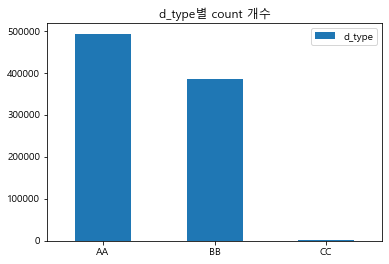

In [8]:
# d_type별 count개수
countbytypes = pd.DataFrame(df['d_type'].value_counts())
countbytypes.plot(kind = 'bar', title = 'd_type별 count 개수', rot = 0);

In [9]:
df['d_type'].value_counts()

AA    493166
BB    384541
CC      1564
Name: d_type, dtype: int64

In [10]:
# d_type이 user_id에 1:1 대응되는 모습
df.groupby('user_id')['d_type'].value_counts()

user_id  d_type
224      AA         2
232      BB        23
342      AA         1
565      AA         2
729      AA         1
                   ..
1830551  BB         1
1830570  BB         1
1830580  AA         1
1830589  BB         1
1830598  AA         1
Name: d_type, Length: 165425, dtype: int64

In [11]:
# d_type이 store_id에 n:m 대응되는 모습
df.groupby('store_id')['d_type'].value_counts()

store_id  d_type
4         AA        13
          BB        12
8         BB        28
          AA        19
161       BB         3
                    ..
231444    AA         1
231453    AA        14
          BB         8
231465    AA        10
          BB         4
Name: d_type, Length: 2272, dtype: int64

##### 2. goods_type

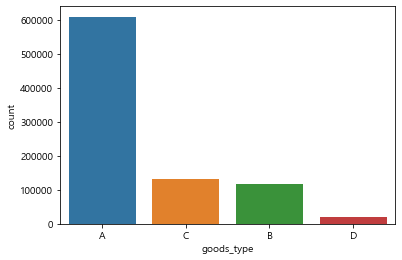

In [12]:
# goods_type 개수
sns.countplot(x = "goods_type", data = df)
plt.show()

In [13]:
df['goods_type'].value_counts()

A    609790
C    131163
B    118541
D     19777
Name: goods_type, dtype: int64

In [14]:
# date별 goods_type의 패턴
df.groupby(['date', 'goods_type']).size().unstack(fill_value=0).loc['2020-01-01':'2020-01-31',:]

goods_type,A,B,C,D
date,,,,
2020-01-01,661,34,210,19
2020-01-02,921,304,197,56
2020-01-03,905,505,268,46
2020-01-04,1553,144,454,37
2020-01-05,1065,56,351,27
2020-01-06,950,276,192,45
2020-01-07,1021,347,225,33
2020-01-08,997,437,195,33
2020-01-09,988,433,255,42


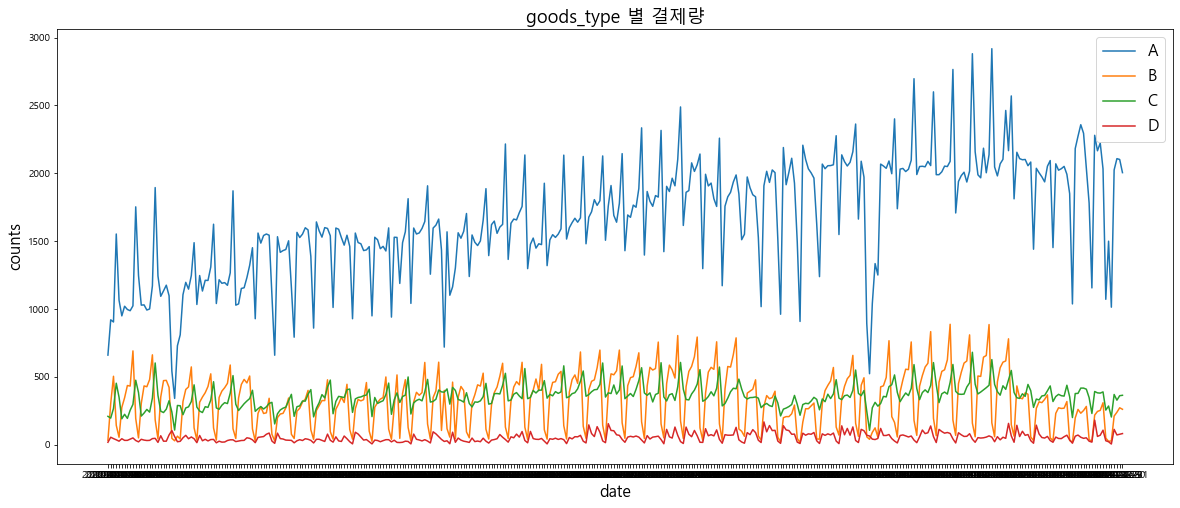

In [15]:
# goods_type 별 결제량 시각화
countbydate = df.groupby(['date', 'goods_type']).size().unstack(fill_value=0)

plt.figure(figsize=(20,8))
sns.lineplot(countbydate.index, countbydate['A'])
sns.lineplot(countbydate.index, countbydate['B'])
sns.lineplot(countbydate.index, countbydate['C'])
sns.lineplot(countbydate.index, countbydate['D'])

plt.legend(['A', 'B', 'C', 'D'], loc='best', fontsize=16)
plt.title('goods_type 별 결제량', fontsize=18)
plt.ylabel('counts', fontsize=16)
plt.xlabel('date', fontsize=16)
plt.xticks(ticks = None)
plt.show()


##### 3. ad1

In [16]:
df['ad1'].unique()

array(['GN', 'J', 'SC', 'MP', 'JRR', 'YD', 'GJ', 'YO', 'GSN', 'GBC', 'BF',
       'DJ', '0', 'CD', 'NO', 'CY', 'YC', 'SD', 'GD', 'GSW', 'DM', 'R',
       'GB', 'GS', 'GHN', 'SB', 'IND', 'P', 'GW', 'JR', 'GEJ', 'GGY',
       'GKP', 'CAS', 'SG', 'BJG', 'BHW', 'GAY', 'GYI', 'CCA', 'PJP',
       'GGC', 'IYS', 'DB', 'GGM', 'GAS', 'WOID', 'DIV', 'AOI', 'COI',
       'GPJ', 'SOI', 'ABP', 'DOI', 'WF', 'BI', 'ZP', 'EP', 'Q', 'BO',
       'ZE', 'RRR', 'QGI', 'DSO', 'SOD', 'BOI', 'WT', 'BP', 'SP', 'CN',
       'SJV', 'SDU', 'QH', 'BUD', 'CU', 'VU', 'WAE', 'NW', 'DY', 'WH',
       'GR', 'X', 'CVB', 'ADS', 'VO'], dtype=object)

<br><br>
### 📋 Data description 재정의

|변수명|정의|값|
|:---:|:---:|:---|
|count|결제 건수||
|join_date|가입일||
|d_type|**결제 수단**|AA : 카드 결제<br>BB : 네이버 페이<br>CC : 휴대폰 결제|
|store_id|점포 주소||
|goods_type|**판매 주차권**|A : 모든 종류의 평일 주간 주차권<br>B : 모든 종류의 평일 야간 주차권<br>C : 모든 종류의 주말 주간 주차권<br>D : 모든 종류의 주말 야간 주차권|
|date|결제일||
|count|결제 건수||
|ad1|**지역 코드**|예) GN : 강남, MP : 마포 ...|

<br>

* goods_type 세분화

|goods_type|주간|야간|
|---|---|---|
|평일|A|B|
|주말|C|D|

* 지역 코드 ad1의 경우, 함께 주어진 외부 데이터가 서울시 중심이라 서울 지역을 세분화한 코드라고 예측.

❗️ **회의를 통해 가장 가능성이 높은 설명을 붙였으며, 정의를 단정짓기는 어려움**


<br><br>
## 🚫 Step 2. 결측치, 이상치 확인

+ 결측치 : 없음
+ 이상치 : 
 - join_date == 1970-01-01 데이터는 치환 없이 삭제하기로 결정 (5.10 회의)
 - user_id == 999665 데이터는 비상식적인 결제량 정보를 담고 있으므로 제거 (찬서님 의견 + 코드)

In [17]:
# Unix time error
df[(df['join_date'] == '1970-01-01')].sort_values(by = 'count', ascending = False)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
368711,1277650,1970-01-01,CC,92264,C,2020-06-26,4,JRR
269797,851134,1970-01-01,CC,190482,A,2020-05-17,3,GN
71522,1493307,1970-01-01,CC,82433,D,2020-02-10,3,CY
590435,1661920,1970-01-01,CC,109877,C,2020-09-18,2,GN
139409,654237,1970-01-01,CC,181777,C,2020-03-17,2,BF
...,...,...,...,...,...,...,...,...
175767,654237,1970-01-01,CC,181777,C,2020-04-03,1,BF
176320,1071641,1970-01-01,CC,221045,A,2020-04-03,1,GN
176853,1355917,1970-01-01,CC,220700,A,2020-04-03,1,GN
176971,1415023,1970-01-01,CC,131081,A,2020-04-03,1,YO


In [18]:
df[(df['user_id'] == 999665)].sort_values(by = 'count', ascending = False).head(10)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
729776,999665,2018-12-16,CC,96266,A,2020-11-07,61,GN
748372,999665,2018-12-16,CC,109677,A,2020-11-13,59,JRR
751974,999665,2018-12-16,CC,1109,A,2020-11-14,58,JRR
726277,999665,2018-12-16,CC,190055,A,2020-11-06,55,SB
767392,999665,2018-12-16,CC,131081,A,2020-11-19,53,YO
687010,999665,2018-12-16,CC,182320,A,2020-10-24,51,JRR
690265,999665,2018-12-16,CC,222401,A,2020-10-25,50,CY
708664,999665,2018-12-16,CC,104067,A,2020-10-31,50,MP
764097,999665,2018-12-16,CC,220607,A,2020-11-18,49,GN
705100,999665,2018-12-16,CC,1900,C,2020-10-30,49,GN


In [19]:
df = df[(df['join_date'] != '1970-01-01')]
df = df[df['user_id'] != 999665]

<br><br><br>
## 🔧Step 3. Feature Engineering 진행

- 1. 외부데이터인 '서울시_기상데이터.csv'를 이용하여 count와 관계가 있을 만한 변수를 가져온다.
- 2. 주어진 데이터의 기본 변수에서 새로운 컬럼을 추가한다.


#### ✅Feature Engineering 을 진행하기 전 먼저 train과 test 데이터를 분류해준다.

In [20]:
# train, test
train = df[df.date <= '2020-09-30']
test = df[df.date > '2020-09-30']
display(train, test)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR
...,...,...,...,...,...,...,...,...
623574,1709914,2020-09-30,BB,221022,B,2020-09-30,1,GN
623575,1709935,2020-09-30,AA,725,B,2020-09-30,1,MP
623576,1709942,2020-09-30,AA,223058,B,2020-09-30,1,BF
623577,1709950,2020-09-30,BB,182320,A,2020-09-30,2,JRR


,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
623579,15521,2014-09-12,AA,182320,A,2020-10-01,1,JRR
623580,17651,2014-09-19,BB,82434,D,2020-10-01,1,J
623581,26388,2014-10-25,BB,182320,A,2020-10-01,1,JRR
623582,81772,2015-05-02,BB,204438,A,2020-10-01,1,DJ
623583,92258,2015-05-24,AA,220745,A,2020-10-01,1,SD
...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J


#### 1. 외부 데이터 Feature Engineering

In [21]:
weather_data = pd.read_csv('서울시_기상데이터.csv', encoding='cp949')
weather_data.dtypes

지점        int64
일시       object
기온      float64
강수량     float64
풍속      float64
습도        int64
일조시간    float64
적설량     float64
지면온도    float64
지중온도    float64
dtype: object

In [22]:
# 데이터 기본 전처리
weather_data['일시'] = weather_data['일시'].astype('datetime64')
weather_data['date'] = weather_data['일시'].dt.date

# 날씨 데이터의 `기온` 컬럼에서 8월 26일 13시 데이터 하나가 결측치로 잡혀있다. 
# 이 부분은 12시 데이터와 14시 데이터를 참고하여 34℃로 삽입했다.
weather_data['기온'] = weather_data['기온'].fillna(34)
weather_data = weather_data.fillna(0)

In [23]:
# 일 최고기온과 누적강수량, 불쾌지수를 구하는 weather_max
weather_data['누적강수량'] = weather_data.groupby('date')['강수량'].cumsum()
weather_data['discomfort'] = (0.81 * weather_data['기온']) + (0.01*weather_data['습도']*(0.99*weather_data['기온']-14.3)) + 46.3
weather_max = weather_data.groupby('date').max().reset_index()

# 누적강수량 15mm를 기준으로 [강한비, 약한비, 해당없음, 눈온날] 로 구분하는 extreme_weather
weather_max['extreme_weather'] = np.where(weather_max["적설량"].values > 0, '눈', np.where(weather_max["누적강수량"].values > 15, '강한비', np.where(weather_max["누적강수량"].values > 0, '약한비', '없음')))

# 날씨 데이터 12월 31일 데이터에는 00시 날씨 정보만 삽입되어 있기 때문에 최고 기온을 고쳐준다.  
weather_max.loc[365, '기온'] = -5

# 불쾌지수를 그룹핑해주는 discomfort_index
weather_max['discomfort_index'] = np.where(weather_max["discomfort"].values > 80, '매우불쾌', np.where(weather_max["discomfort"].values > 70, '불쾌', '쾌적'))

# 변수명을 최고기온으로 맞춰주고, date의 type을 시간데이터로 맞춰서 머지
weather_max = weather_max.rename(columns = {'기온': 'max_temp'}, inplace = False)
weather_max = weather_max[['date', 'max_temp', 'discomfort_index', 'extreme_weather']]
df['date'] = df['date'].astype('datetime64')
weather_max['date'] = weather_max['date'].astype('datetime64')
df = pd.merge(df, weather_max, how = 'left', on = 'date')

#### 2. 기본 변수에 대한 Feature Engineering

In [24]:
# 기본 날짜 데이터 쪼개기
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['week'] = df['date'].dt.isocalendar().week

# 공휴일 추가
df['isholiday'] = df['date'].isin(['2020-01-01', '2020-01-24', '2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25'])

# 몇개월차 유저인가
df['join_date'] = df['join_date'].astype('datetime64')
df['howlonguser'] = (df['year']*12 + df['month']) - (df['join_date'].dt.year*12 + df['join_date'].dt.month) + 1

In [25]:
# 해당 날짜까지의 누적 카운트를 구하는 freq_cum과 활성화 정도를 보여주는 active를 구하기 위한 코드

# 누적 결제 횟수
df_l = df.sort_values(['user_id','date']).reset_index(drop=True)
df_l['next'] = df_l.sort_values(['user_id','date']).groupby('user_id')['date'].shift(-1)
df_l['before'] = df_l.sort_values(['user_id','date']).groupby('user_id')['date'].shift(1)
df_l['freq_cum'] = pd.DataFrame(df_l.groupby(['user_id','date'])['before'].count()).groupby('user_id')['before'].cumsum().values
df_l['ranking'] = np.where(df_l["freq_cum"].values <= 1 , '브론즈', np.where(df_l["freq_cum"].values <= 5 , '실버', np.where(df_l["freq_cum"].values <= 18 , '골드', '플레티넘')))

In [26]:
# ranking을 분류하는 기준은 누적 카운트의 통계량을 기준으로 정했음
df_l['freq_cum'].describe()

count                877,812
mean                      15
std                       24
min                        0
25%                        1
50%                        5
75%                       18
max                      243
Name: freq_cum, dtype: float64

In [27]:
# 활성화 정도를 보여주는 active를 구하기
# 주의할 점 : active는 현시점(2020-12-31)을 기준으로 고객을 분류하기 때문에 EDA에서만 사용하고 모델링에서는 반드시 제거해줘야함

df_l['comeback'] = (pd.to_datetime('2020-12-31') - df_l['date']).dt.days

# 최근 결제 날짜
www = pd.DataFrame(df_l.groupby(['user_id'])['comeback'].min()).reset_index()
www = www.rename(columns = {'comeback': 'min_cb'}, inplace = False)

# 최대 누적 카운트
eee = pd.DataFrame(df_l.groupby(['user_id'])['freq_cum'].max()).reset_index()
eee = eee.rename(columns = {'freq_cum': 'max_freq'}, inplace = False)

df_cb = pd.merge(www, eee, how = 'left', on = 'user_id')
df_l = pd.merge(df_l, df_cb, how = 'left', on = ['user_id'])
df_l['active'] = np.where(df_l['min_cb'] <= 31, '활성유저', np.where(df_l['max_freq'] >= 5, '잠수유저', '비활성유저'))

In [28]:
# freq_cum과  active를 df에 머지
freqbyuser = df_l[['user_id', 'date', 'freq_cum', 'ranking', 'active']]
df = pd.merge(df, freqbyuser, how = 'left', on = ['user_id', 'date'])

####################### howlonguser를 기준으로 고객 등급 매기기
df['howlong'] = np.where(df['howlonguser'] <= 3, '1~3', np.where(df['howlonguser'] <= 6, '3~6', np.where(df['howlonguser'] <= 12, '6~12', np.where(df['howlonguser'] <= 24, '1년차', '2년 이상'))))

In [29]:
# 각 그룹에 대한 데이터는 균형있게 들어갔는지 확인
df['ranking'].value_counts()

브론즈     255588
골드      218012
플레티넘    216979
실버      187233
Name: ranking, dtype: int64

In [30]:
df['active'].value_counts()

활성유저     380526
잠수유저     294942
비활성유저    202344
Name: active, dtype: int64

In [31]:
df['howlong'].value_counts()

1~3      219630
2년 이상    201190
1년차      187005
6~12     156922
3~6      113065
Name: howlong, dtype: int64

<br><br>
#### 🔧Feature Engineering 내용 정리

1. 주어진 서울시 기상데이터 csv 파일로 `weather`, `mean_temp`, `temp_diff` 변수를 추가했다.
    - weather : 날씨 ('눈', '비', '해당없음')
    - mean_temp : 평균 온도
    - temp_diff : 일교차 (일 최고기온 - 최저기온)
<br> 주어진 데이터에서 기온 값에 하나의 NA값이 존재하는데, max나 min에 영향을 받지 않을 정도의 숫자 30을 임의로 집어넣었다.
<br>또한 12월 31일 날짜에는 00시 데이터만 있다. 12월 31 날짜의 평균 온도와 일교차는 아래 링크를 참고하여 데이터를 삽입했다.<br>  https://www.weather.go.kr/weather/climate/past_cal.jsp?stn=108&yy=2020&mm=12&x=20&y=5&obs=1
<br><br>
2. date 변수를 연, 월, 일자, 날짜, 주차로 쪼개서 저장하여 각각 `year`, `month`, `day`, `weekday`, `week`의 변수를 추가했다.
<br><br>
3. (결제년월 - 가입년월)로 몇 개월차 유저인지 파악하는 변수 `howlonguser`를 만들었다.
<br><br>
4. 국가 공휴일 데이터인 `isholiday` 변수를 추가했다. 다음의 사이트를 참고하였다.<br>
https://publicholidays.co.kr/ko/2020-dates/
<br><br>
5. 누적 결제를 카운트하는 `freq_cum`을 만들고 `freq_cum`의 통계량을 바탕으로 회원 등급을 매기는 `ranking` 컬럼을 만들었다. (지인님 코드)
    - 브론즈 : 0 ~ 1회
    - 실버 : 2 ~ 5회
    - 골드 : 6 ~18회
    - 플래티넘 : 19회 이상
<br><br>
6. 2020년 12월 31일을 기준으로 유저의 활성화 정도를 확인하는 `active` 컬럼을 만들었다.
    - 활성유저 : 한 달 이내 결제 건이 있는 유저
    - 잠수유저 : 한 달 이내 결제 건은 없지만 이전 count 건수가 5회 이상인 유저
    - 비활성유저 : 한 달 이내 결제 건도 없고, 이전 count 건수가 5회 미만인 유저
    
#### ⚠️ year와 active컬럼은 모델링 과정에서 drop해야하는 컬럼이다

## 🚙 Step 4. EDA

#### 1. count
종속 변수이기 때문에 필수적으로 살펴본다.

In [32]:
# count
df['count'].value_counts()

1     862704
2      13500
3       1058
4        270
5        133
6         63
7         36
9         12
8         11
10         6
15         4
11         3
12         3
13         3
23         2
22         1
17         1
19         1
20         1
Name: count, dtype: int64

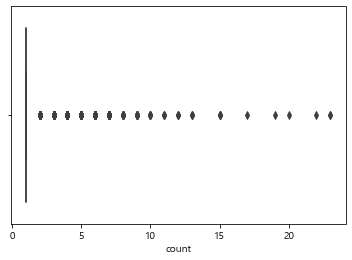

In [33]:
# count == 1이 아니면 전부 이상치로 판단하는 모습
sns.boxplot(x = "count",
            data = df)
plt.show()

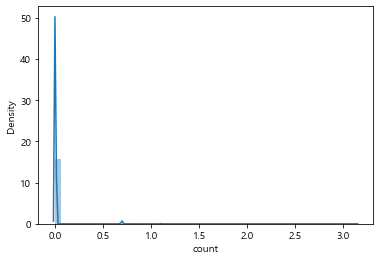

In [34]:
# count 빈도 log
sns.distplot(np.log(df['count']));

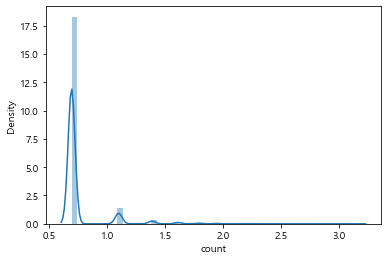

In [35]:
# count != 1 빈도
withoutcount1 = df.drop(df[df['count'] == 1].index)
sns.distplot(np.log(withoutcount1['count']));

<br>

#### 2. corrplot

상관 분석을 위해 corrplot을 그려본다.

count == 1의 값이 압도적으로 많으므로, count == 1을 제외한 데이터의 corrplot도 함께 살펴본다.

##### 1) count == 1 포함 corrplot

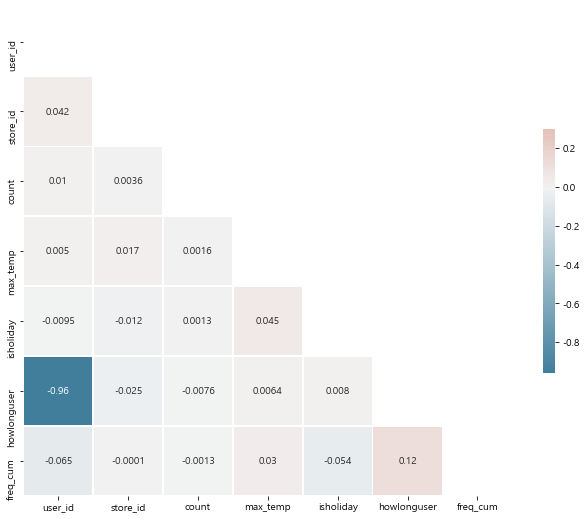

In [36]:
df_corr = df.drop(['year', 'month', 'day', 'weekday', 'week'], 1)

corr = df_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

##### 2) count != 1 데이터의 corrplot

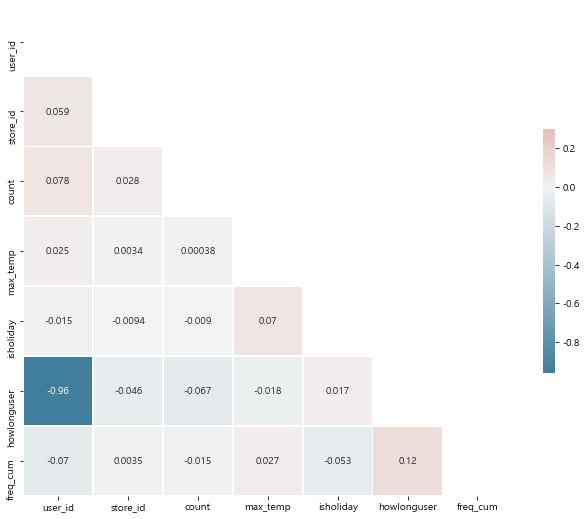

In [37]:
no_one = df_corr[df_corr['count'] != 1]

corr = no_one.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

#### corrplot 결과

0. 데이터가 갖는 편향성(count == 1이 압도적) 때문에 corrplot으로 count와 다른 feature들과의 상관관계를 정확히 파악하기 힘듬
1. count가 1인 경우를 제외하면서 corrplot을 살펴보았을 때도 마찬가지임
2. 2020년 결제 데이터라 `year` 변수는 모델링 관점에서는 의미가 없음
3. `howlonguser`와 `user_id`의 상관계수가 -1에 가깝기 때문에 모델링 시 하나의 변수는 제거 가능

#### 3. Features

##### Q1) 요일별 결제량은 어떻게 변할까?

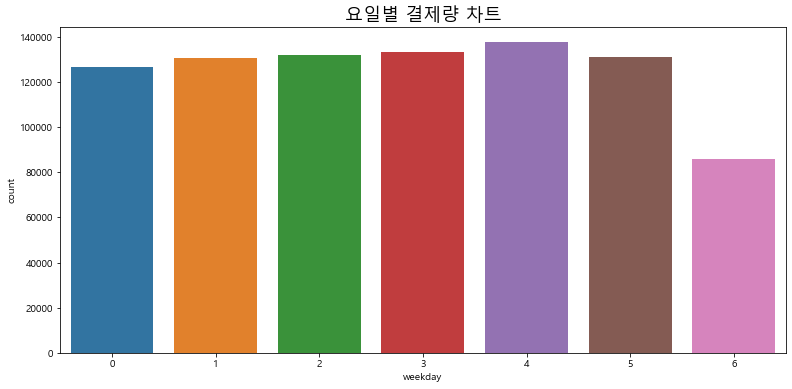

In [38]:
plt.figure(figsize=(13,6))
sns.countplot(data = df, x = 'weekday')
plt.title('요일별 결제량 차트', fontsize=18);

- 금요일 결제량이 더 높다는 점 외엔 월요일부터 토요일까지는 큰 변화가 없지만, 일요일 결제량은 크게 감소하는 것을 확인할 수 있다.
<br><br>

##### Q2) 월별 결제량 차트는 어떻게 나타날까?

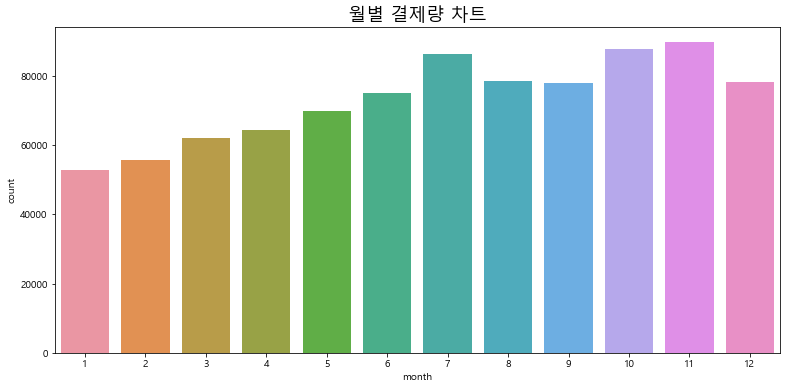

In [39]:
plt.figure(figsize=(13,6))
sns.countplot(data = df, x = 'month')
plt.title('월별 결제량 차트', fontsize=18);

- 2020년 결제건만 존재하기 때문에 월별 결제량 차트의 유의미한 해석이 불가능해보인다.
<br><br>

<br>

##### Q3) 최고 기온에 따른 이용량은 어떻게 나타날까?

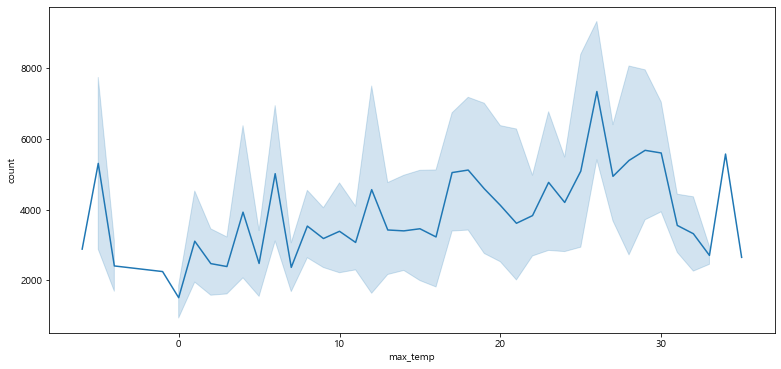

In [40]:
# 평균 온도에 따른 이용량 추이
plt.figure(figsize=(13,6))
df_m_temp = df.groupby('max_temp')['count'].sum().reset_index()
df_m_temp['max_temp'] = round(df_m_temp['max_temp'])
sns.lineplot(data = df_m_temp, x = 'max_temp', y = 'count');

- 최고 기온에 따른 이용량을 보면, 25 ~ 27℃ 사이에 결제량이 많은 걸 확인할 수 있다. (그래프는 최고 기온의 소수점 첫째자리에서 반올림)

- 한편 데이터가 2020년에 제한된 데이터이기 때문에, 날짜와 관련된 차트는 유의성을 판단하기가 어렵다.

##### Q4) 불쾌지수에 가장 민감한 반응을 보인 유저는 어떤 유저일까?

In [41]:
zzz = df[df['discomfort_index'] == "매우불쾌"]

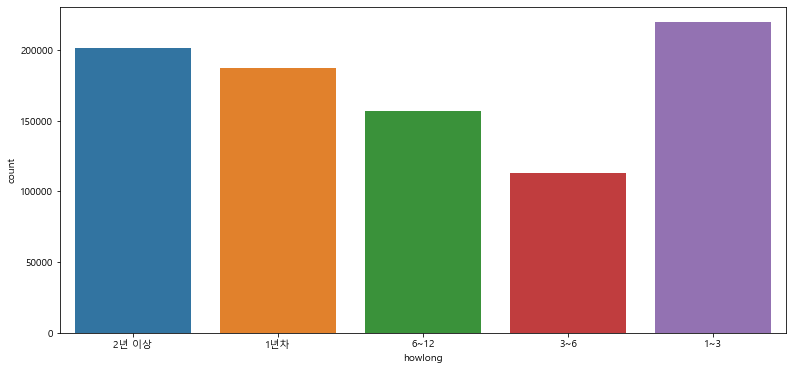

In [42]:
plt.figure(figsize=(13,6))
sns.countplot(x = "howlong",  data = df)
plt.show()

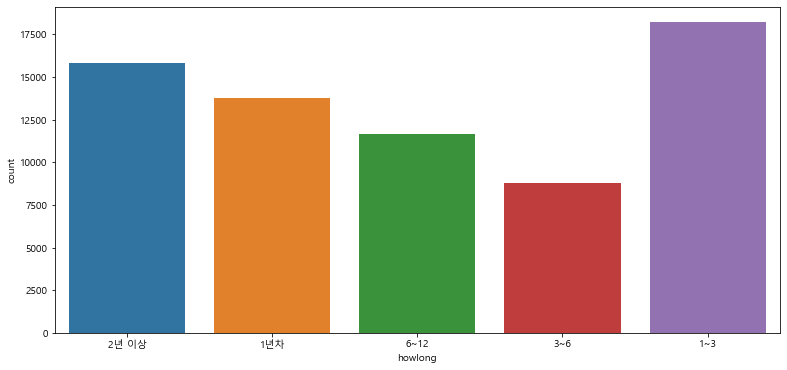

In [43]:
plt.figure(figsize=(13,6))
sns.countplot(x = "howlong",  data = zzz)
plt.show()

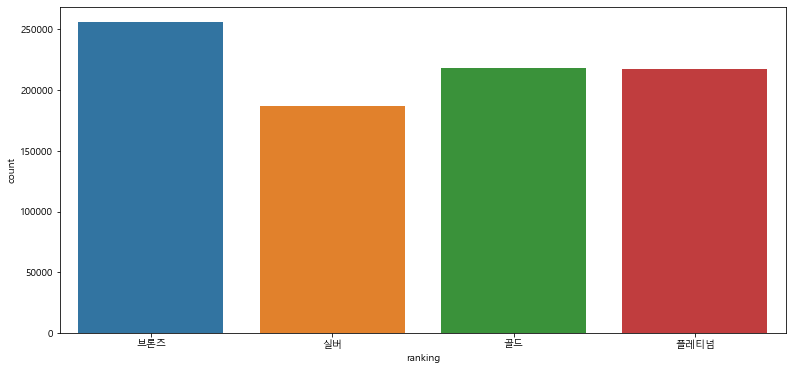

In [44]:
plt.figure(figsize=(13,6))
sns.countplot(x = "ranking",  data = df, order = ['브론즈', '실버', '골드', '플레티넘'])
plt.show()

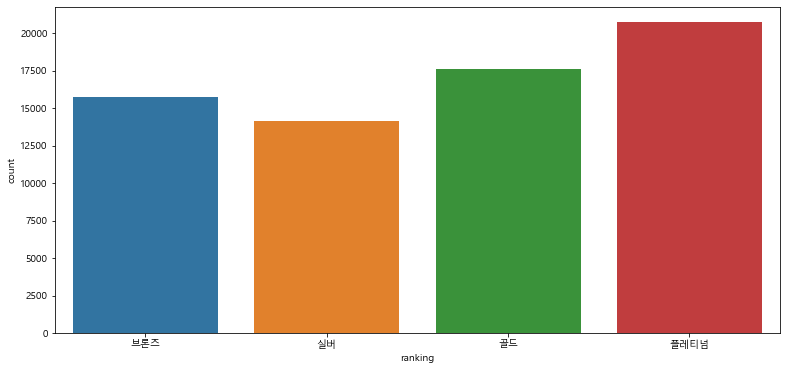

In [45]:
plt.figure(figsize=(13,6))
sns.countplot(x = "ranking", data = zzz, order = ['브론즈', '실버', '골드', '플레티넘'])
plt.show()

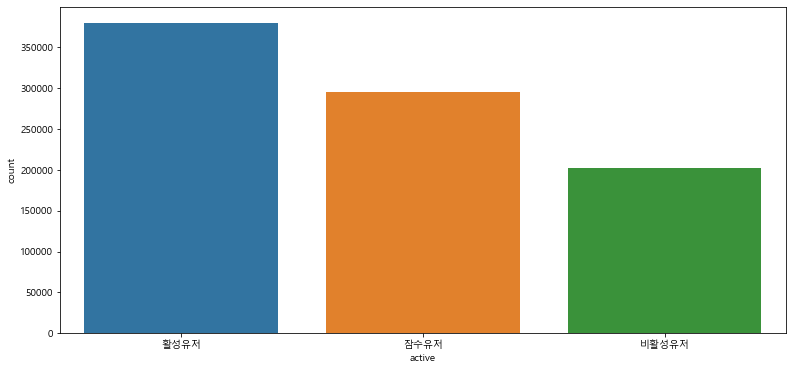

In [46]:
plt.figure(figsize=(13,6))
sns.countplot(x = "active", data = df, order = ['활성유저', '잠수유저', '비활성유저'])
plt.show()

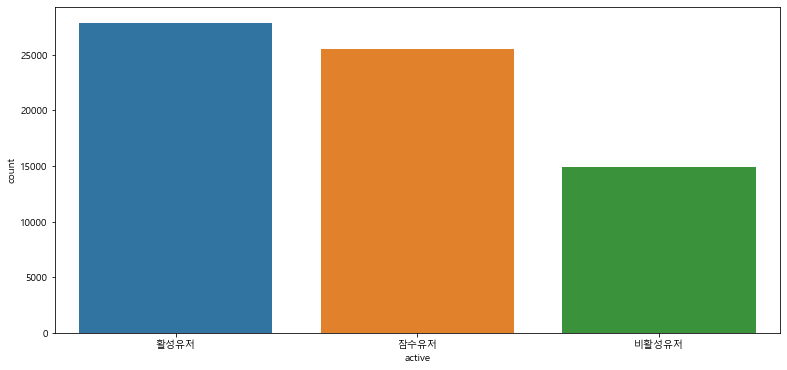

In [47]:
plt.figure(figsize=(13,6))
sns.countplot(x = "active", data = zzz,order = ['활성유저', '잠수유저', '비활성유저'])
plt.show()

- ranking으로 보았을 때는 플래티넘 유저가, active로 보았을 때는 잠수 유저가 불쾌지수가 높은 날에 상대적으로 더 많이 이용했다.

aa1 = df['active'].value_counts().reset_index()
aa2 = df[df['discomfort_index'] == '불쾌']['active'].value_counts().reset_index()
aa3 = pd.concat([aa1.transpose(), aa2.transpose()])
aa3 = aa3.loc["active"]
aa3 = aa3.rename(columns = {0: '활성유저', 1:'잠수유저', 2:'비활성유저'}, inplace = False)

stacked_data = aa3.apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, rot=0)
plt.title("불쾌지수에 따른 이용량 변화")
plt.xlabel(" ");

bb1 = df['howlong'].value_counts().reset_index()
bb2 = df[df['discomfort_index'] == '불쾌']['howlong'].value_counts().reset_index()
bb3 = pd.concat([bb1.transpose(), bb2.transpose()])
bb3 = bb3.loc["howlong"]
bb3 = bb3.rename(columns = {0: '1~3', 1:'3~6', 2:'6~12', 3:'1년차', 4:'2년 이상'}, inplace = False)
stacked_data = bb3.apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, rot=0)
plt.title("Mince Pie Consumption Breakdown")
plt.xlabel(" ");

cc1 = df['ranking'].value_counts().reset_index()
cc2 = df[df['discomfort_index'] == '불쾌']['ranking'].value_counts().reset_index()
cc3 = pd.concat([cc1.transpose(), cc2.transpose()])
cc3 = cc3.loc["ranking"]
cc3 = cc3.rename(columns = {0: '브론즈', 1:'골드', 2:'플래티넘', 3:'실버'}, inplace = False)
stacked_data = cc3.apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, rot=0)
plt.title("Mince Pie Consumption Breakdown")
plt.xlabel(" ");

##### Q5) extreme_weather에 구애받지 않는 유저는?

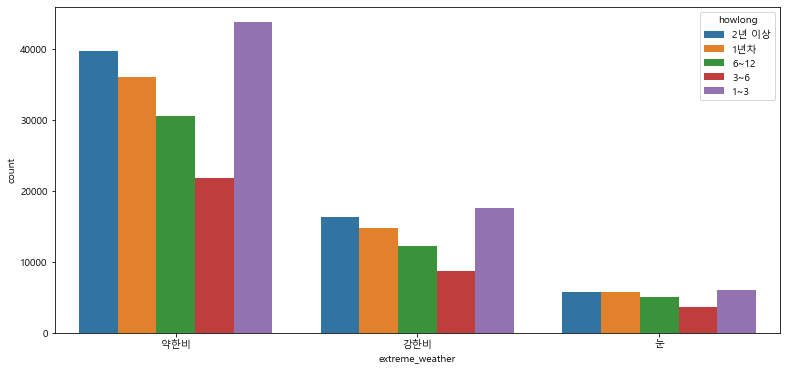

In [48]:
plt.figure(figsize=(13,6))
sns.countplot(x = "extreme_weather",  hue = "howlong", data = df[df['extreme_weather'] != "없음"])
plt.show()

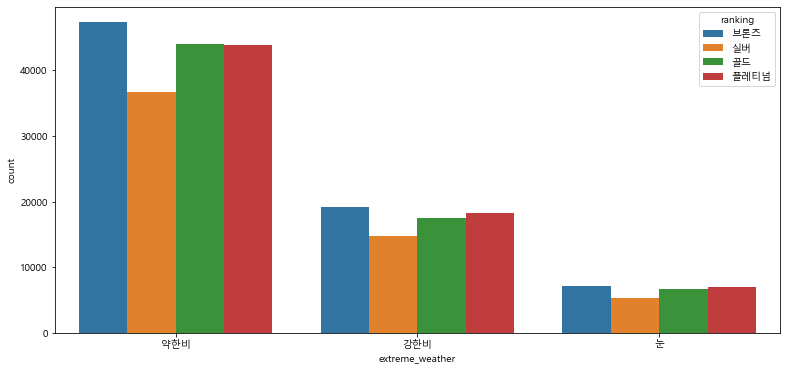

In [49]:
plt.figure(figsize=(13,6))
sns.countplot(x = "extreme_weather",  hue = "ranking", data = df[df['extreme_weather'] != "없음"])
plt.show()

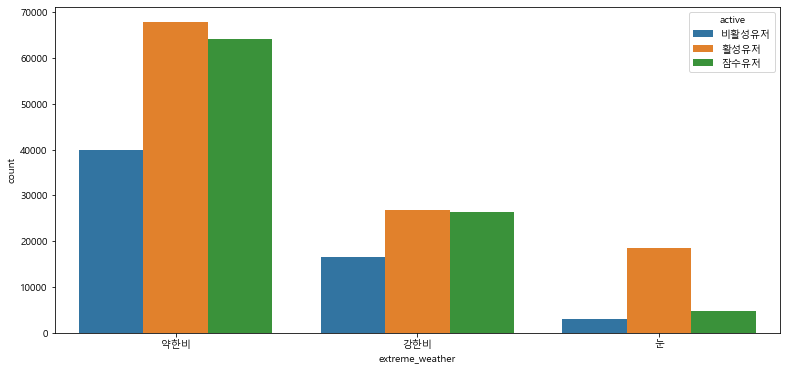

In [50]:
plt.figure(figsize=(13,6))
sns.countplot(x = "extreme_weather",  hue = "active", data = df[df['extreme_weather'] != "없음"])
plt.show()

- extreme_weather에 대한 반응은 howlong과 ranking에서는 나타나지 않는다.
- 활성유저는 눈이 오늘 날 주차장을 찾기 위한 활동에 조금 더 적극적이다.

In [51]:
snow = df[df['extreme_weather'] == '눈'][['user_id', 'join_date', 'date']].drop_duplicates()
print(len(snow))
snow['gap'] = (snow['date'] - snow['join_date']).dt.days
len(snow[snow['gap'] == 0])


26211


901

- 한편 2020년 눈이 내리는 날에 모두의 주차장 앱에 가입하여 결제까지 진행한 유저는 901명으로, 전체 눈 오는 날 결제 건수의 3.4% 정도이다.

##### Q6) 유저의 가입기간, 등급, 활성화 정도에 따라 날짜별 이용이 어떻게 달라질까?

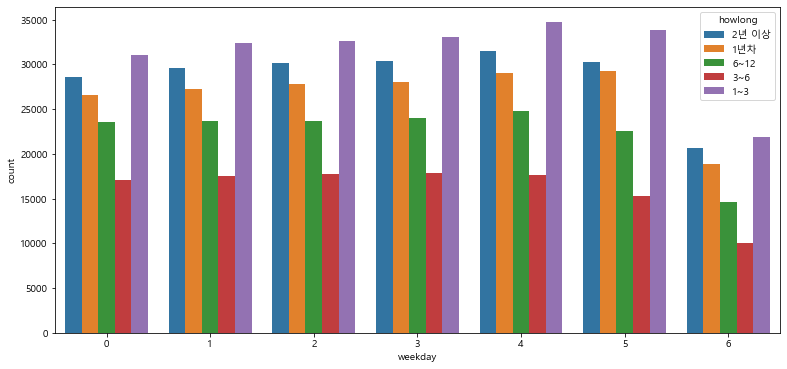

In [52]:
plt.figure(figsize=(13,6))
sns.countplot(x = "weekday",  hue = "howlong", data = df)
plt.show()

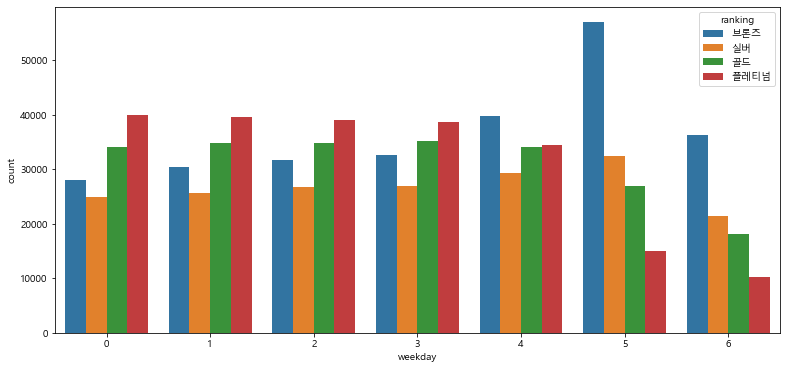

In [53]:
plt.figure(figsize=(13,6))
sns.countplot(x = "weekday",  hue = "ranking", data = df)
plt.show()

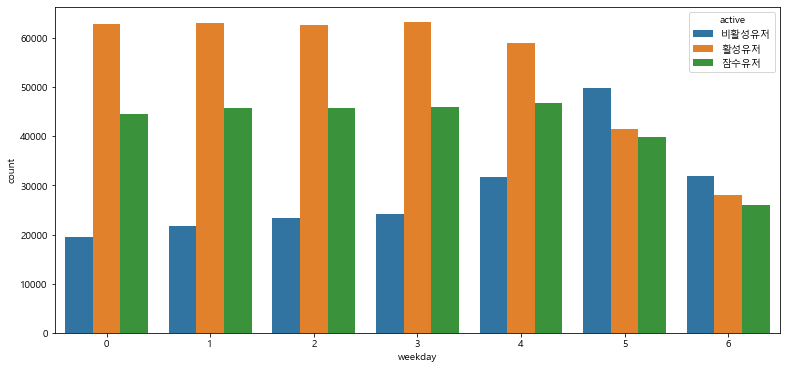

In [54]:
plt.figure(figsize=(13,6))
sns.countplot(x = "weekday",  hue = "active", data = df)
plt.show()

- 유저의 가입기간에 따른 날짜별 이용량은 큰 차이가 없다.
- 등급이 높은 유저일수록(모두의 주차장 앱을 많이 이용한 유저일수록) 주중 이용 횟수가 주말 이용 횟수보다 많아진다. 
- 활성유저는 평일 이용량이 주말보다 높다. 
- 잠수유저의 이용량 추이는 활성유저와 비슷하지만, 비활성 유저의 경우는 정반대로 이용량이 금토일에 집중적으로 나타났다. 

##### Q7) 유저의 가입기간, 등급, 활성화 정도에 따라 goods_type 이용이 어떻게 달라질까?

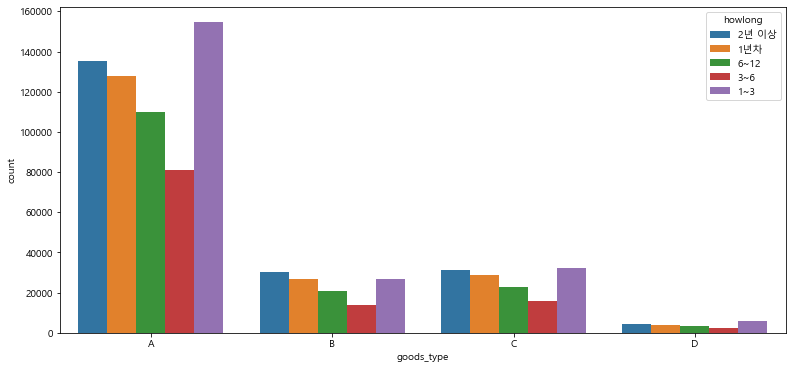

In [55]:
plt.figure(figsize=(13,6))
sns.countplot(x = "goods_type",  hue = "howlong", data = df, order = ['A', 'B', 'C', 'D'])
plt.show()

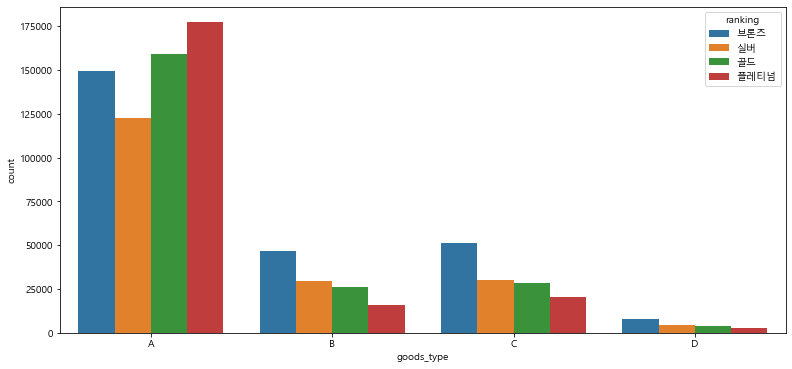

In [56]:
plt.figure(figsize=(13,6))
sns.countplot(x = "goods_type",  hue = "ranking", data = df, order = ['A', 'B', 'C', 'D'])
plt.show()

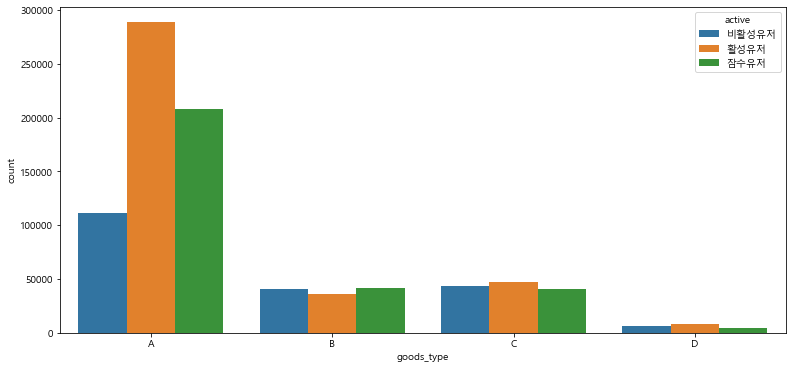

In [57]:
plt.figure(figsize=(13,6))
sns.countplot(x = "goods_type",  hue = "active", data = df, order = ['A', 'B', 'C', 'D'])
plt.show()

- 가입 기간에 따른 goods_type 이용의 차이는 보이지 않는다.
- 등급에 따라 goods_type 이용을 살펴보았을 때, 모두의 주차장 앱을 많이 이용한 유저(골드, 플레티넘)일수록 type A를 많이 이용하는 것으로 보인다. 
- 그리고 이용량이 적은 유저(브론즈, 실버)일수록 상대적으로 B와 C type을 더 구매하는 것을 알 수 있다.
- 유저 활성화는 goods_type의 관계에서 재미있는 건 비율에 상관없이 B, C, D를 이용하는 건수가 엇비슷하다는 점이다. 하지만 전반적으로 Type A를 가장 많이 이용한다.

### 🚙 EDA 내용 정리

1. count == 1 값이 압도적이라 corrplot에서 모든 feature가 count와의 상관관계 값을 0으로 갖는다. 로그를 씌워도 정규성 확보가 어렵다.

2. corrplot의 상관관계는 count가 1인 경우를 제외하고 보더라도 크게 달라지지 않는다. 이외에도 다른 방식으로 살펴보았는데 count가 8 이상일 때 상관계수에 의미있는 숫자들이 등장했다. 그렇지만 이 경우는 데이터가 70개 정도로 상관 분석을 하기에 적당하지 않다. 따라서 해당 데이터로 상관관계를 분석하는 것은 의미가 없다고 판단한다.

# 모델을 통한 예측 - by rows
변수별 EDA를 바탕으로 모델을 통한 예측에 사용할 최종 컬럼 확정
- 기본 변수 : user_id, store_id, d_type, goods_type, ad1, weekday, isholiday
- 피쳐엔지니어링 변수 : max_temp, discomfort_index, extreme_weather

In [58]:
df_model = df.copy()
df_model

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,max_temp,discomfort_index,extreme_weather,year,month,day,weekday,week,isholiday,howlonguser,freq_cum,ranking,active,howlong
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,0,쾌적,약한비,2020,1,1,2,1,True,73,0,브론즈,비활성유저,2년 이상
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,0,쾌적,약한비,2020,1,1,2,1,True,72,0,브론즈,비활성유저,2년 이상
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,0,쾌적,약한비,2020,1,1,2,1,True,63,0,브론즈,비활성유저,2년 이상
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,0,쾌적,약한비,2020,1,1,2,1,True,62,0,브론즈,활성유저,2년 이상
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,0,쾌적,약한비,2020,1,1,2,1,True,62,0,브론즈,비활성유저,2년 이상
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877807,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,-5,쾌적,없음,2020,12,31,3,53,False,1,0,브론즈,활성유저,1~3
877808,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,-5,쾌적,없음,2020,12,31,3,53,False,1,0,브론즈,활성유저,1~3
877809,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,-5,쾌적,없음,2020,12,31,3,53,False,1,0,브론즈,활성유저,1~3
877810,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,-5,쾌적,없음,2020,12,31,3,53,False,1,0,브론즈,활성유저,1~3


In [59]:
# train set (2020-01 ~ 2020-09)
df_train = df_model[df_model['date'] <= '2020-09-30']
df_train

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,max_temp,discomfort_index,extreme_weather,year,month,day,weekday,week,isholiday,howlonguser,freq_cum,ranking,active,howlong
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,0,쾌적,약한비,2020,1,1,2,1,True,73,0,브론즈,비활성유저,2년 이상
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,0,쾌적,약한비,2020,1,1,2,1,True,72,0,브론즈,비활성유저,2년 이상
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,0,쾌적,약한비,2020,1,1,2,1,True,63,0,브론즈,비활성유저,2년 이상
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,0,쾌적,약한비,2020,1,1,2,1,True,62,0,브론즈,활성유저,2년 이상
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,0,쾌적,약한비,2020,1,1,2,1,True,62,0,브론즈,비활성유저,2년 이상
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622328,1709914,2020-09-30,BB,221022,B,2020-09-30,1,GN,26,불쾌,강한비,2020,9,30,2,40,True,1,0,브론즈,비활성유저,1~3
622329,1709935,2020-09-30,AA,725,B,2020-09-30,1,MP,26,불쾌,강한비,2020,9,30,2,40,True,1,0,브론즈,비활성유저,1~3
622330,1709942,2020-09-30,AA,223058,B,2020-09-30,1,BF,26,불쾌,강한비,2020,9,30,2,40,True,1,0,브론즈,비활성유저,1~3
622331,1709950,2020-09-30,BB,182320,A,2020-09-30,2,JRR,26,불쾌,강한비,2020,9,30,2,40,True,1,0,브론즈,비활성유저,1~3


In [60]:
# test set (2020-10 ~ 2020-12) 
df_test = df_model[df_model['date'] > '2020-09-30']
df_test

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,max_temp,discomfort_index,extreme_weather,year,month,day,weekday,week,isholiday,howlonguser,freq_cum,ranking,active,howlong
622333,15521,2014-09-12,AA,182320,A,2020-10-01,1,JRR,23,불쾌,없음,2020,10,1,3,40,True,74,0,브론즈,비활성유저,2년 이상
622334,17651,2014-09-19,BB,82434,D,2020-10-01,1,J,23,불쾌,없음,2020,10,1,3,40,True,74,1,브론즈,비활성유저,2년 이상
622335,26388,2014-10-25,BB,182320,A,2020-10-01,1,JRR,23,불쾌,없음,2020,10,1,3,40,True,73,1,브론즈,비활성유저,2년 이상
622336,81772,2015-05-02,BB,204438,A,2020-10-01,1,DJ,23,불쾌,없음,2020,10,1,3,40,True,66,6,골드,활성유저,2년 이상
622337,92258,2015-05-24,AA,220745,A,2020-10-01,1,SD,23,불쾌,없음,2020,10,1,3,40,True,66,1,브론즈,비활성유저,2년 이상
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877807,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,-5,쾌적,없음,2020,12,31,3,53,False,1,0,브론즈,활성유저,1~3
877808,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,-5,쾌적,없음,2020,12,31,3,53,False,1,0,브론즈,활성유저,1~3
877809,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,-5,쾌적,없음,2020,12,31,3,53,False,1,0,브론즈,활성유저,1~3
877810,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,-5,쾌적,없음,2020,12,31,3,53,False,1,0,브론즈,활성유저,1~3


In [61]:
# 모델 예측에 불필요한 컬럼 지우기
x_train = df_train.drop(['count', 'join_date', 'date', 'year', 'week', 'month', 'day', 'howlonguser', 'freq_cum', 'ranking', 'active', 'howlong'], axis = 1)
x_test = df_test.drop(['count', 'join_date', 'date', 'year', 'week', 'month', 'day', 'howlonguser', 'freq_cum', 'ranking', 'active', 'howlong'], axis = 1)
y_train = df_train['count']
y_test = df_test['count']

## 전처리 함수

In [62]:
# 원핫인코딩 전처리함수 (참고용)
from sklearn.preprocessing import OneHotEncoder

def onehotencoding(x_train, x_test):
    tmp_x_train = x_train.copy()
    tmp_x_test  = x_test.copy()
    
    # reset index
    tmp_x_train = tmp_x_train.reset_index(drop=True)
    tmp_x_test  = tmp_x_test.reset_index(drop=True)
    
    # cat_columns 원핫인코딩
    ohe = OneHotEncoder(sparse=False)
    x_all = pd.concat([tmp_x_train[cat_columns], 
                       tmp_x_test[cat_columns]], axis=0)

    new_x_all = ohe.fit_transform(x_all)
    
    ohe_columns = []
    for cat in ohe.categories_:
        ohe_columns += cat.tolist()
    
    new_x_all = pd.DataFrame(new_x_all, columns=ohe_columns)

    new_x_train_cat = new_x_all.iloc[:tmp_x_train.shape[0], :]
    new_x_test_cat =  new_x_all.iloc[tmp_x_train.shape[0]:, :]

    new_x_train_cat = new_x_train_cat.reset_index(drop=True)
    new_x_test_cat  = new_x_test_cat.reset_index(drop=True)

    tmp_x_train = tmp_x_train.drop(columns=cat_columns)
    tmp_x_test  = tmp_x_test.drop(columns=cat_columns)

    tmp_x_train = pd.concat([tmp_x_train, new_x_train_cat], axis=1)
    tmp_x_test = pd.concat([tmp_x_test, new_x_test_cat], axis=1)
    
    return tmp_x_train, tmp_x_test

In [63]:
# 라벨인코딩 전처리함수
from sklearn.preprocessing import LabelEncoder

def labelencoding(x_train, x_test):
    tmp_x_train = x_train.copy()
    tmp_x_test  = x_test.copy()
    
    # reset index
    tmp_x_train = tmp_x_train.reset_index(drop=True)
    tmp_x_test  = tmp_x_test.reset_index(drop=True)

    # cat_columns 라벨인코딩
    le = LabelEncoder()
    x_all = pd.concat([tmp_x_train[cat_columns], tmp_x_test[cat_columns]], axis=0)
    new_x_all = x_all.apply(LabelEncoder().fit_transform)
    
    new_x_train_cat = new_x_all.iloc[:tmp_x_train.shape[0], :]
    new_x_test_cat =  new_x_all.iloc[tmp_x_train.shape[0]:, :]

    new_x_train_cat = new_x_train_cat.reset_index(drop=True)
    new_x_test_cat  = new_x_test_cat.reset_index(drop=True)

    tmp_x_train = tmp_x_train.drop(columns=cat_columns)
    tmp_x_test  = tmp_x_test.drop(columns=cat_columns)

    tmp_x_train = pd.concat([tmp_x_train, new_x_train_cat], axis=1)
    tmp_x_test = pd.concat([tmp_x_test, new_x_test_cat], axis=1)
    
    return tmp_x_train, tmp_x_test

In [64]:
# 범주형 변수 컬럼 cat_columns로 구분
cat_columns = [c for c, t in zip(x_train.dtypes.index, x_train.dtypes) if t == 'O'] 
other_columns = [c for c in x_train.columns if c not in cat_columns]
print(f'Categorical Columns: \n{cat_columns}\n\n Other Columns: \n{other_columns}')

Categorical Columns: 
['d_type', 'goods_type', 'ad1', 'discomfort_index', 'extreme_weather']

 Other Columns: 
['user_id', 'store_id', 'max_temp', 'weekday', 'isholiday']


In [65]:
# 범주형 변수 라벨인코딩 진행
x_train, x_test = labelencoding(x_train, x_test)

In [66]:
x_train.head(2)

,user_id,store_id,max_temp,weekday,isholiday,d_type,goods_type,ad1,discomfort_index,extreme_weather
0,2858,1892,0,2,True,0,0,39,2,2
1,5647,182009,0,2,True,1,0,49,2,2


In [67]:
x_test.head(2)

,user_id,store_id,max_temp,weekday,isholiday,d_type,goods_type,ad1,discomfort_index,extreme_weather
0,15521,182320,23,3,True,0,0,51,1,3
1,17651,82434,23,3,True,1,3,49,1,3


In [68]:
# 트리계열 모델인 RandomForest, XGBoost, LightGBM 성능 비교
# MAE, MSE 기준 가장 좋은 성능을 내는 모델 : LightGBM

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

models = [['RandomForest', RandomForestRegressor()], 
          ['XGBoost', XGBRegressor(n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(n_jobs=-1)]]

best_loss_mae = np.inf
best_loss_mse = np.inf

for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss_mae = mean_absolute_error(y_test, y_pred)
    current_loss_mse = mean_squared_error(y_test, y_pred)
    
    if current_loss_mae < best_loss_mae:
        best_loss_mae  = current_loss_mae
        best_model_mae = [i, name, model]
    print(f'{name} Model Mean Absolute Error: {best_loss_mae}')
    
    if current_loss_mse < best_loss_mse:
        best_loss_mse  = current_loss_mse
        best_model_mse = [i, name, model]
    print(f'{name} Model Mean Squared Error: {best_loss_mse}')
    
print(f'Best Model (MAE기준): {best_model_mae[-2]}, MAE : {best_loss_mae}')
print(f'Best Model (MSE기준): {best_model_mse[-2]}, MSE : {best_loss_mse}')

RandomForest Model Mean Absolute Error: 0.1039716907120686
RandomForest Model Mean Squared Error: 0.060305595935775405
XGBoost Model Mean Absolute Error: 0.06645161923656705
XGBoost Model Mean Squared Error: 0.04855314458967977
LightGBM Model Mean Absolute Error: 0.042518711718247997
LightGBM Model Mean Squared Error: 0.039516388918371864
Best Model (MAE기준): LightGBM, MAE : 0.042518711718247997
Best Model (MSE기준): LightGBM, MSE : 0.039516388918371864


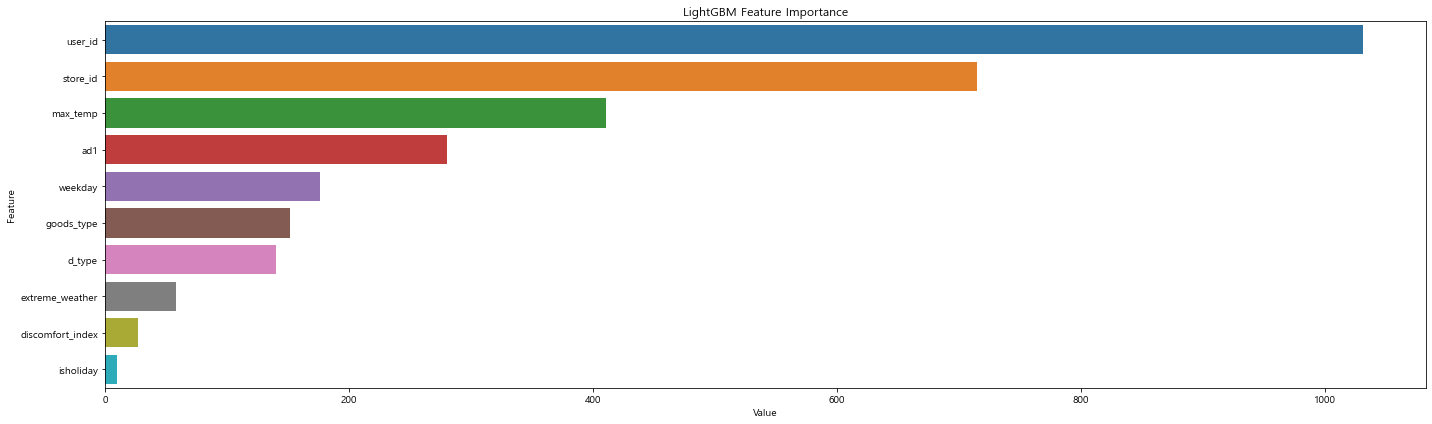

In [69]:
# Feature importance
feature_imp = pd.DataFrame(sorted(zip(best_model_mse[-1].feature_importances_,x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

# (추가분석) 모델을 통한 예측 - by user_id & pay_yearmonth¶

In [70]:
df_model['pay_yearmonth'] = df_model['date'].dt.strftime('%Y-%m')
df_model

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,max_temp,discomfort_index,extreme_weather,year,month,day,weekday,week,isholiday,howlonguser,freq_cum,ranking,active,howlong,pay_yearmonth
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,0,쾌적,약한비,2020,1,1,2,1,True,73,0,브론즈,비활성유저,2년 이상,2020-01
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,0,쾌적,약한비,2020,1,1,2,1,True,72,0,브론즈,비활성유저,2년 이상,2020-01
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,0,쾌적,약한비,2020,1,1,2,1,True,63,0,브론즈,비활성유저,2년 이상,2020-01
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,0,쾌적,약한비,2020,1,1,2,1,True,62,0,브론즈,활성유저,2년 이상,2020-01
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,0,쾌적,약한비,2020,1,1,2,1,True,62,0,브론즈,비활성유저,2년 이상,2020-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877807,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,-5,쾌적,없음,2020,12,31,3,53,False,1,0,브론즈,활성유저,1~3,2020-12
877808,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,-5,쾌적,없음,2020,12,31,3,53,False,1,0,브론즈,활성유저,1~3,2020-12
877809,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,-5,쾌적,없음,2020,12,31,3,53,False,1,0,브론즈,활성유저,1~3,2020-12
877810,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,-5,쾌적,없음,2020,12,31,3,53,False,1,0,브론즈,활성유저,1~3,2020-12


In [71]:
from scipy import stats

df_final = df_model.groupby(['user_id', 'pay_yearmonth'])['d_type','store_id','goods_type','ad1','count'].agg({
    'd_type' : lambda x: stats.mode(x)[0],
    'store_id' : lambda x: stats.mode(x)[0],
    'goods_type' : lambda x: stats.mode(x)[0],
    'ad1' : lambda x: stats.mode(x)[0],
    'count' : 'sum'}).reset_index()
df_final

,user_id,pay_yearmonth,d_type,store_id,goods_type,ad1,count
0,224,2020-01,AA,92510,A,J,1
1,224,2020-12,AA,181833,C,J,1
2,232,2020-01,BB,28018,C,JRR,4
3,232,2020-02,BB,28018,A,J,2
4,232,2020-03,BB,28018,A,JRR,2
...,...,...,...,...,...,...,...
374987,1830551,2020-12,BB,219886,B,GN,1
374988,1830570,2020-12,BB,82433,B,CY,1
374989,1830580,2020-12,AA,92020,B,JRR,1
374990,1830589,2020-12,BB,92437,B,J,1


In [76]:
df_final['pay_yearmonth'].sort_values().unique()

array(['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
       '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12'],
      dtype=object)

In [77]:
# train set (2020-01 ~ 2020-09)
df_train = df_final[df_final['pay_yearmonth'].isin(['2020-01', '2020-02', '2020-03', '2020-04',
                                                    '2020-05', '2020-06','2020-07', '2020-08', '2020-09'])]
df_train

,user_id,pay_yearmonth,d_type,store_id,goods_type,ad1,count
0,224,2020-01,AA,92510,A,J,1
2,232,2020-01,BB,28018,C,JRR,4
3,232,2020-02,BB,28018,A,J,2
4,232,2020-03,BB,28018,A,JRR,2
5,232,2020-04,BB,28018,C,JRR,4
...,...,...,...,...,...,...,...
352242,1709914,2020-09,BB,221022,B,GN,1
352252,1709935,2020-09,AA,725,B,MP,1
352253,1709942,2020-09,AA,223058,B,BF,1
352254,1709950,2020-09,BB,182320,A,JRR,2


In [78]:
# test set (2020-10 ~ 2020-12) 
df_test = df_final[df_final['pay_yearmonth'].isin(['2020-10', '2020-11', '2020-12'])]
df_test

,user_id,pay_yearmonth,d_type,store_id,goods_type,ad1,count
1,224,2020-12,AA,181833,C,J,1
10,232,2020-10,BB,173268,A,J,2
11,232,2020-11,BB,173268,A,J,2
12,342,2020-10,AA,92264,A,JRR,1
14,565,2020-11,AA,220087,B,GN,1
...,...,...,...,...,...,...,...
374987,1830551,2020-12,BB,219886,B,GN,1
374988,1830570,2020-12,BB,82433,B,CY,1
374989,1830580,2020-12,AA,92020,B,JRR,1
374990,1830589,2020-12,BB,92437,B,J,1


In [81]:
# 피쳐, 라벨로 분리하기
x_train = df_train.drop(['count', 'pay_yearmonth'], axis = 1)
x_test = df_test.drop(['count', 'pay_yearmonth'], axis = 1)
y_train = df_train['count']
y_test = df_test['count']

In [82]:
# 범주형 변수 컬럼 cat_columns로 구분
cat_columns = [c for c, t in zip(x_train.dtypes.index, x_train.dtypes) if t == 'O'] 
other_columns = [c for c in x_train.columns if c not in cat_columns]
print(f'Categorical Columns: \n{cat_columns}\n\n Other Columns: \n{other_columns}')

Categorical Columns: 
['d_type', 'goods_type', 'ad1']

 Other Columns: 
['user_id', 'store_id']


In [83]:
# 범주형 변수 라벨인코딩 진행
x_train, x_test = labelencoding(x_train, x_test)

In [84]:
# 트리계열 모델인 RandomForest, XGBoost, LightGBM 성능 비교
# MAE, MSE 기준 가장 좋은 성능을 내는 모델 : RandomForest

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

models = [['RandomForest', RandomForestRegressor()], 
          ['XGBoost', XGBRegressor(n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(n_jobs=-1)]]

best_loss_mae = np.inf
best_loss_mse = np.inf

for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss_mae = mean_absolute_error(y_test, y_pred)
    current_loss_mse = mean_squared_error(y_test, y_pred)
    
    if current_loss_mae < best_loss_mae:
        best_loss_mae  = current_loss_mae
        best_model_mae = [i, name, model]
    print(f'{name} Model Mean Absolute Error: {best_loss_mae}')
    
    if current_loss_mse < best_loss_mse:
        best_loss_mse  = current_loss_mse
        best_model_mse = [i, name, model]
    print(f'{name} Model Mean Squared Error: {best_loss_mse}')
    
print(f'Best Model (MAE기준): {best_model_mae[-2]}, MAE : {best_loss_mae}')
print(f'Best Model (MSE기준): {best_model_mse[-2]}, MSE : {best_loss_mse}')

RandomForest Model Mean Absolute Error: 1.478833084217106
RandomForest Model Mean Squared Error: 8.076889567927303
XGBoost Model Mean Absolute Error: 1.478833084217106
XGBoost Model Mean Squared Error: 8.076889567927303
LightGBM Model Mean Absolute Error: 1.478833084217106
LightGBM Model Mean Squared Error: 8.076889567927303
Best Model (MAE기준): RandomForest, MAE : 1.478833084217106
Best Model (MSE기준): RandomForest, MSE : 8.076889567927303


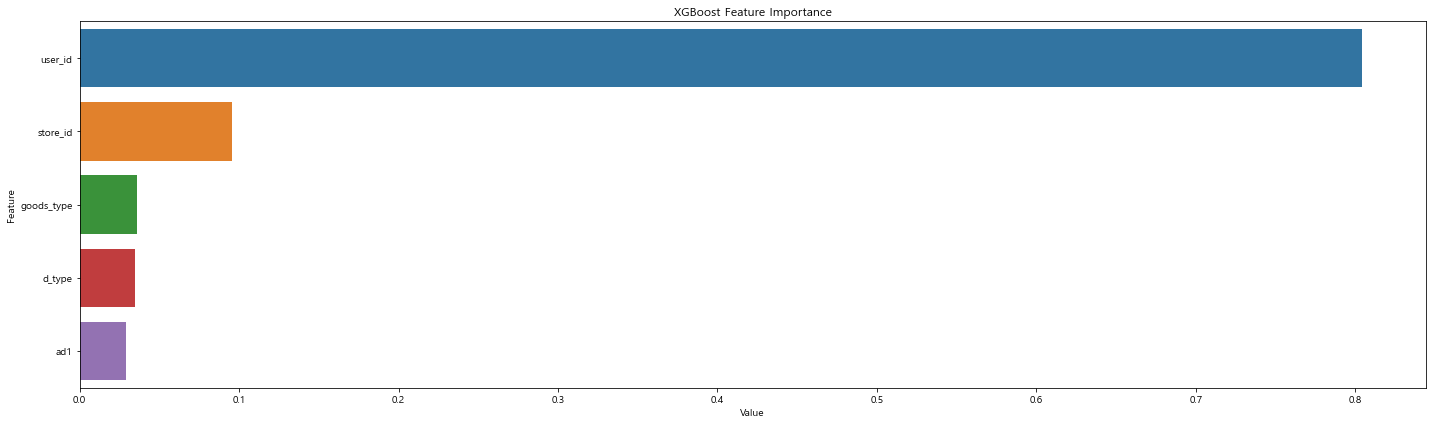

In [87]:
# Feature importance
feature_imp = pd.DataFrame(sorted(zip(best_model_mse[-1].feature_importances_,x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

⚡<b>인사이트</b>⚡
- user_id, pay_yearmonth로 groupby한 데이터셋으로 유저별, 월별 이용건수를 예측하였을 때는 RandomForest가 가장 좋은 성능을 보임
- user_id가 압도적으로 높은 feature importance를 보여 유저별 특성 파악 및 이를 활용한 프로모션 전략이 유효할 것으로 예상됨

# 결론
## 분석 한계점
- 전체 유저 중 서비스를 1회만 이용한 유저의 비중이 약 44.7%로, 서비스를 여러번 이용한 유저의 데이터가 더 축적되면 향후 이용건수 예측 정확도를 보다 높일 수 있을 것으로 보임<br>
- 서비스 이용시간에 대한 정보(date 컬럼), store의 구체적인 주소에 대한 정보(ad1 컬럼)가 있었다면 기상, 교통량 정보를 보다 정확하게 활용할 수 있을 것으로 보임

## 제안 방안
<b>유저별 특성을 반영한 프로모션</b>
- 잠수 유저는 평일 할인권, 비활성유저는 금토일 할인권 제공 
- 신규유저(브론즈 등급)에게는 금토일 할인권 제공, 오래된 유저일수록 평일 할인권 제공 

<b>기상, 교통량 조건을 반영한 프로모션</b>
- 폭염, 폭우, 폭설이 있거나 불쾌지수가 높을 것으로 예상되는 날 할인권 제공
- 교통량이 높을 것으로 예상되는 날 할인권 제공